In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from rectools.dataset import Dataset
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.models import PopularModel, EASEModel, SASRecModel, ImplicitALSWrapperModel
from rectools.model_selection import TimeRangeSplitter, cross_validate

from implicit.als import AlternatingLeastSquares
from catboost import CatBoostRanker, Pool

/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
interactions = pd.read_csv("data/interactions.csv")
items = pd.read_csv("data/items.csv")
users = pd.read_csv("data/users.csv")

# EDA

Посмотрим на данные

In [3]:
interactions

,user_id,item_id,action,datetime
0,0,53.0,click,2025-01-17 10:04:17.216954590
1,0,7.0,click,2025-01-11 02:47:00.259085350
2,0,92.0,click,2025-03-11 04:40:18.978093997
3,0,9.0,click,2025-02-08 00:59:21.139311191
4,0,47.0,click,2025-01-15 15:46:51.046877007
...,...,...,...,...
4808789,9999,0.0,show,2025-01-25 17:35:43.151033886
4808790,9999,23.0,show,2025-01-25 17:35:43.151033886
4808791,9999,78.0,show,2025-01-25 17:35:43.151033886
4808792,9999,63.0,show,2025-01-25 17:35:43.151033886


In [4]:
interactions['action'].value_counts()

action
show     4709108
click      99686
Name: count, dtype: int64

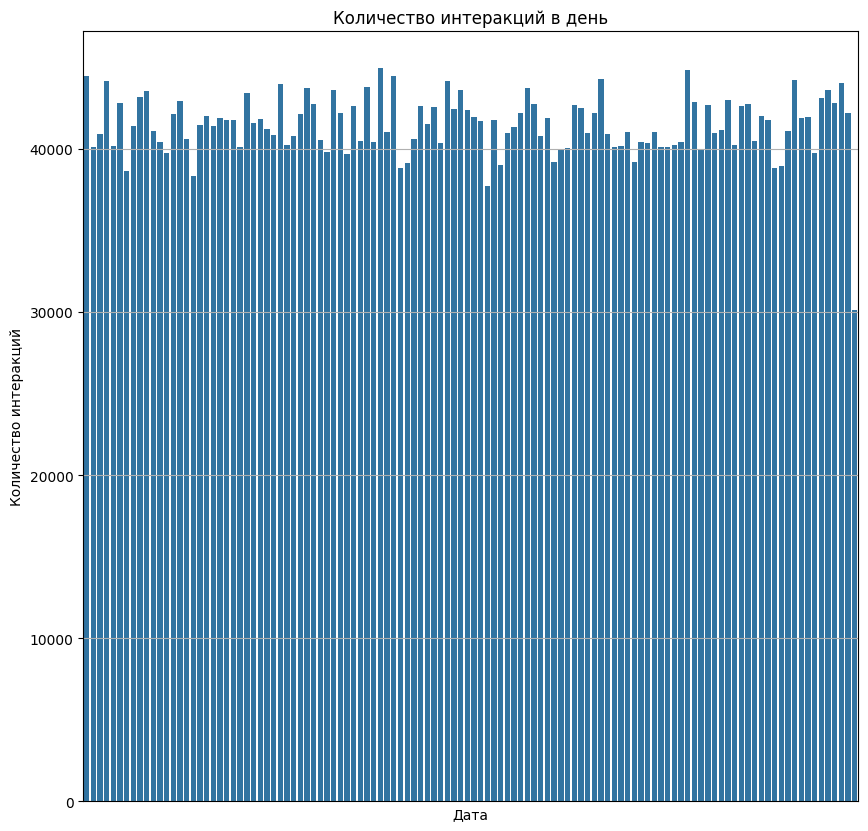

In [5]:
interactions_plot_df = interactions.copy()
interactions_plot_df["date"] = pd.to_datetime(interactions_plot_df["datetime"]).dt.date

interactions_plot_df = interactions_plot_df.groupby(["date"])[interactions_plot_df.columns[0]].count().reset_index()


plt.figure(figsize=(10,10))
sns.barplot(x='date', y='user_id', data=interactions_plot_df)
plt.xlabel('Дата')
plt.xticks([])
plt.ylabel('Количество интеракций')
plt.title('Количество интеракций в день')
plt.grid(True)
plt.show()

In [6]:
items

,item_id,genre,mean_users_score
0,0,Комедия,1.872701
1,1,Комедия,4.753572
2,2,Мелодрама,3.659970
3,3,Комедия,2.993292
4,4,Мелодрама,0.780093
...,...,...,...
95,95,Комедия,2.468978
96,96,Мелодрама,2.613664
97,97,Драма,2.137705
98,98,Мелодрама,0.127096


In [7]:
items.value_counts("genre")

genre
Триллер       27
Комедия       20
Мелодрама     20
Фантастика    17
Драма         16
Name: count, dtype: int64

In [8]:
users

,user_id,sex_type
0,0,F
1,1,F
2,2,F
3,3,M
4,4,F
...,...,...
9995,9995,M
9996,9996,M
9997,9997,M
9998,9998,M


In [9]:
users.value_counts("sex_type")

sex_type
F    5036
M    4964
Name: count, dtype: int64

# Готовим модели

Разделим выборку на 2 части  по времени:


На 1 - ой части мы будем обучать модели, доступные из коробки в rectools, а также считать фичи для катбуста

На 2 - ой части мы будем стакать результаты моделей в катбуст

In [10]:
interactions["weight"] = 1.0

def split_time(datetimes, test_size=0.5):
    datetimes_sorted = datetimes.sort_values().reset_index(drop=True)
    split_date = datetimes_sorted[int(datetimes_sorted.shape[0] * test_size)]
    return datetimes_sorted[datetimes_sorted < split_date].reset_index(drop=True), datetimes_sorted[datetimes_sorted >= split_date].reset_index(drop=True)
    
first_part, second_part = split_time(interactions["datetime"])

interactions_first_period = interactions[interactions["datetime"].isin(first_part)]
interactions_second_period = interactions[interactions["datetime"].isin(second_part)]

# Для некоторых моделе нужны только позитивные взаимодействия
positive_interactions_first_period = interactions_first_period[interactions_first_period["action"] == "click"]


Инициируем рекоменедателные модели

In [11]:
dataset = Dataset.construct(
    interactions_df=positive_interactions_first_period,
)

sasrec = SASRecModel(
    session_max_len=20,
    loss="softmax",
    n_factors=64,
    n_blocks=1,
    n_heads=4,
    dropout_rate=0.2,
    lr=0.001,
    batch_size=128,
    epochs=1,
    verbose=1,
    deterministic=True,
)
ease = EASEModel()
als = ImplicitALSWrapperModel(AlternatingLeastSquares(factors=32))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Посомтрим качество баовых моделей

In [12]:
splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=5,
    filter_already_seen=True,
)

models = {
    "popular": PopularModel(),
    "ease": ease,
   "sasrec": sasrec,
   "als": als
}

metrics = {
    "HitRate@10": HitRate(k=10),
    "MAP@10": MAP(k=10),
    "Serendipity@10": Serendipity(k=10),
    "CoveredUsers@10": CoveredUsers(k=10),  # how many test users received recommendations
    "AvgRecPopularity@10": AvgRecPopularity(k=10),  # average popularity of recommended items
    "Intersection@10": Intersection(k=10),  # intersection with recommendations from reference model
}

K_RECS = 10

cv_results = cross_validate(
    dataset=dataset,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
    ref_models=["popular"],  # pass reference model to calculate recommendations intersection
    validate_ref_models=True,
)

pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])
)
pivot_results.columns = pivot_results.columns.droplevel(1)
pivot_results

/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/dataset/identifiers.py:60: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unq_values = pd.unique(values)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/models/nn/item_net.py:134: UserWarning: Ignoring `CatFeaturesItemNet` block because dataset doesn't contain item features.
  warnings.warn(explanation)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=('rectools.models.nn.item...net.CatFeaturesItemNet'), input_type=tuple])
  return self.__pydantic_serializer__.to_python(
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/p

Epoch 0: 100%|██████████| 47/47 [00:01<00:00, 36.27it/s, v_num=72, train_loss=4.850]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 47/47 [00:01<00:00, 36.23it/s, v_num=72, train_loss=4.850]


/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/dataset/identifiers.py:60: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unq_values = pd.unique(values)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/models/nn/item_net.py:134: UserWarning: Ignoring `CatFeaturesItemNet` block because dataset doesn't contain item features.
  warnings.warn(explanation)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=('rectools.models.nn.item...net.CatFeaturesItemNet'), input_type=tuple])
  return self.__pydantic_serializer__.to_python(
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/p

Epoch 0: 100%|██████████| 58/58 [00:00<00:00, 59.31it/s, v_num=73, train_loss=4.870]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 58/58 [00:00<00:00, 59.21it/s, v_num=73, train_loss=4.870]


/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/dataset/identifiers.py:60: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unq_values = pd.unique(values)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/models/nn/item_net.py:134: UserWarning: Ignoring `CatFeaturesItemNet` block because dataset doesn't contain item features.
  warnings.warn(explanation)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=('rectools.models.nn.item...net.CatFeaturesItemNet'), input_type=tuple])
  return self.__pydantic_serializer__.to_python(
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/p

Epoch 0: 100%|██████████| 66/66 [00:01<00:00, 50.82it/s, v_num=74, train_loss=4.830]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 66/66 [00:01<00:00, 50.76it/s, v_num=74, train_loss=4.830]


/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/dataset/identifiers.py:60: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unq_values = pd.unique(values)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/models/nn/item_net.py:134: UserWarning: Ignoring `CatFeaturesItemNet` block because dataset doesn't contain item features.
  warnings.warn(explanation)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=('rectools.models.nn.item...net.CatFeaturesItemNet'), input_type=tuple])
  return self.__pydantic_serializer__.to_python(
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/p

Epoch 0: 100%|██████████| 71/71 [00:01<00:00, 59.73it/s, v_num=75, train_loss=4.820]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 71/71 [00:01<00:00, 59.57it/s, v_num=75, train_loss=4.820]


/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/dataset/identifiers.py:60: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unq_values = pd.unique(values)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/models/nn/item_net.py:134: UserWarning: Ignoring `CatFeaturesItemNet` block because dataset doesn't contain item features.
  warnings.warn(explanation)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=('rectools.models.nn.item...net.CatFeaturesItemNet'), input_type=tuple])
  return self.__pydantic_serializer__.to_python(
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/p

Epoch 0: 100%|██████████| 74/74 [00:01<00:00, 54.93it/s, v_num=76, train_loss=4.790]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 74/74 [00:01<00:00, 54.82it/s, v_num=76, train_loss=4.790]


,HitRate@10,MAP@10,AvgRecPopularity@10,Serendipity@10,Intersection@10_popular,CoveredUsers@10
model,,,,,,
popular,0.165288,0.037686,421.453245,0.000015,1.000000,1.0
ease,0.200566,0.050022,373.077659,0.003526,0.189299,1.0
sasrec,0.165946,0.038582,397.932945,0.001980,0.300745,1.0
als,0.182708,0.045396,385.481655,0.003293,0.121801,1.0


Обучаем наши модели на 1-ой части данных

In [13]:
%%time
sasrec.fit(dataset)
ease.fit(dataset)
als.fit(dataset)

/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/dataset/identifiers.py:60: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unq_values = pd.unique(values)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/rectools/models/nn/item_net.py:134: UserWarning: Ignoring `CatFeaturesItemNet` block because dataset doesn't contain item features.
  warnings.warn(explanation)
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=('rectools.models.nn.item...net.CatFeaturesItemNet'), input_type=tuple])
  return self.__pydantic_serializer__.to_python(
/Users/sykuznets3/.pyenv/versions/test_master_class/lib/python3.13/site-packages/p

Epoch 0: 100%|██████████| 76/76 [00:01<00:00, 55.24it/s, v_num=77, train_loss=4.790]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 76/76 [00:01<00:00, 55.18it/s, v_num=77, train_loss=4.790]
CPU times: user 1.36 s, sys: 161 ms, total: 1.52 s
Wall time: 1.89 s


In [36]:
# Скорим базовые модели
recom_sasrec = sasrec.recommend(users=dataset.user_id_map.external_ids, dataset=dataset, filter_viewed=True, k=100).drop(columns=['rank']).rename(columns={"score": "sasrec_score"})
recom_ease = ease.recommend(users=dataset.user_id_map.external_ids, dataset=dataset, filter_viewed=True, k=100).drop(columns=['rank']).rename(columns={"score": "ease_score"})
recom_als = als.recommend(users=dataset.user_id_map.external_ids, dataset=dataset, filter_viewed=True, k=100).drop(columns=['rank']).rename(columns={"score": "als_score"})

# Добавим нормировку
def normilise(data):
    return (data - data.mean()) / data.std()

recom_sasrec["sasrec_score"] = normilise(recom_sasrec["sasrec_score"])
recom_ease["ease_score"] = normilise(recom_ease["ease_score"])
recom_als["als_score"] = normilise(recom_als["als_score"])

# Обучаемся - на логах
target_df = interactions_second_period[["user_id", "item_id"]]
target_df["target"] = interactions_second_period["action"].map({"click": 1, "show": 0})

# Собираем общий датасет
all_features = target_df
all_features = all_features.merge(users, on=["user_id"], how="left")
all_features = all_features.merge(items, on=["item_id"], how="left")
all_features = all_features.merge(recom_sasrec, on=["user_id", "item_id"], how="left")
all_features = all_features.merge(recom_ease, on=["user_id", "item_id"], how="left")
all_features = all_features.merge(recom_als, on=["user_id", "item_id"], how="left")

all_features = all_features.fillna(0)

all_features

/var/folders/ld/vywms60d4_7281vl54t27ngwdqgvkl/T/ipykernel_72290/2506218634.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df["target"] = interactions_second_period["action"].map({"click": 1, "show": 0})


,user_id,item_id,target,sex_type,genre,mean_users_score,sasrec_score,ease_score,als_score
0,0,92.0,1,F,Триллер,3.803925,0.713913,0.524060,0.764742
1,0,13.0,1,F,Триллер,1.061696,-0.765748,0.927354,0.683692
2,0,49.0,1,F,Мелодрама,0.924272,1.205254,1.573210,0.399290
3,0,4.0,1,F,Мелодрама,0.780093,0.495366,2.194181,2.464005
4,0,77.0,1,F,Драма,0.370223,1.011612,0.334235,-0.041085
...,...,...,...,...,...,...,...,...,...
2404427,9999,45.0,0,M,Триллер,3.312611,1.384051,0.429075,0.509701
2404428,9999,87.0,0,M,Комедия,3.187787,-1.113327,-0.724356,-0.121391
2404429,9999,81.0,0,M,Фантастика,3.116491,0.546683,0.132674,0.574376
2404430,9999,20.0,0,M,Триллер,3.059264,0.801675,-1.272496,-1.250150


In [15]:
# Разделяем пользователей на тренировочную и валидационную выборки - важно что бы пользователь полностью попал либо в трейн, kb,j d dfkblfwb.
train_users, val_users = train_test_split(all_features["user_id"].drop_duplicates(), test_size=0.25, random_state=42)

data_train = all_features[all_features["user_id"].isin(train_users)].sort_values("user_id")
data_val = all_features[all_features["user_id"].isin(val_users)].sort_values("user_id")

X_train = data_train.drop(columns="target")
X_val = data_val.drop(columns="target")
y_train = data_train["target"]
y_val = data_val["target"]

In [16]:
train_pool = Pool(data=X_train.drop(columns=["user_id", "item_id"]), label=y_train, group_id=X_train["user_id"], cat_features=['sex_type', 'genre'])
val_pool = Pool(data=X_val.drop(columns=["user_id", "item_id"]), label=y_val, group_id=X_val["user_id"], cat_features=['sex_type', 'genre'])


model = CatBoostRanker(
    iterations=100,             
    learning_rate=0.1,          
    depth=6,                    
    early_stopping_rounds=3
)

model.fit(train_pool, eval_set=val_pool) 


Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.3587081	best: 0.3587081 (0)	total: 1.31s	remaining: 2m 10s
1:	test: 0.3991962	best: 0.3991962 (1)	total: 2.11s	remaining: 1m 43s
2:	test: 0.5313613	best: 0.5313613 (2)	total: 2.83s	remaining: 1m 31s
3:	test: 0.5524521	best: 0.5524521 (3)	total: 3.6s	remaining: 1m 26s
4:	test: 0.5654187	best: 0.5654187 (4)	total: 4.28s	remaining: 1m 21s
5:	test: 0.5715802	best: 0.5715802 (5)	total: 4.96s	remaining: 1m 17s
6:	test: 0.5824953	best: 0.5824953 (6)	total: 5.64s	remaining: 1m 14s
7:	test: 0.5919504	best: 0.5919504 (7)	total: 6.33s	remaining: 1m 12s
8:	test: 0.5909034	best: 0.5919504 (7)	total: 7s	remaining: 1m 10s
9:	test: 0.6089443	best: 0.6089443 (9)	total: 7.7s	remaining: 1m 9s
10:	test: 0.6105948	best: 0.6105948 (10)	total: 8.37s	remaining: 1m 7s
11:	test: 0.6127348	best: 0.6127348 (11)	total: 9.1s	remaining: 1m 6s
12:	test: 0.6147849	best: 0.6147849 (12)	total: 9.87s	remaining: 1m 6s
13:	test: 0.6149052	best: 0.6149052 (13)	tota